In [117]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LeaveOneOut

**Exercise 15.1** Gaussian processes will grow in complexity during optimization process as more samples accumulate. how can this be an advantage over model based on regression?

**Answer:** A regression model will have a fixed number of parameters, and will not be able to adapt to new data. A Gaussian process will be able to adapt to new data, and will be able to model more complex functions.

**Exercise 15.2**  How does computational complexity of prediction with a Gaussian process increase with the number of data points $m$?

**Answer:** The computational complexity of prediction with a Gaussian process is $O(m^3)$ as it requires inverting an $m \times m$ matrix.

**Exercise 15.3**  Consider the function $f(x) = \sin(x)/x$ over $[-5, 5]$. Plot the 95% confidence bounds for a Gaussian process with derivative information fitted to the evaluations at $[-5, -2.5, 0, 2.5, 5]$. What is the maximum standard deviation in the predicted distribution within $[-5, 5]$? How many function evaluations, evenly-spaced over the domain, are needed such that a Gaussian process without derivative information achieves the same maximum predictive standard deviation?

Assume zero-mean functions and noise-free observations, and use the covariance functions:

$$
k_{ff}(x, x') = \text{exp}\left(-\frac{1}{2}(x - x')^2\right)
$$

$$
k_{\nabla f}(x, x') = (x' - x) \text{exp}\left(-\frac{1}{2}(x - x')^2\right)
$$

$$
k_{\nabla\nabla}(x, x') = ((x - x')^2 - 1) \text{exp}\left(-\frac{1}{2}(x - x')^2\right)
$$


**Answer:**  

In [118]:
def function(x):
    if x == 0:
        return 1
    else:
        return np.sin(x)/x

def derivative(x):
    if x == 0:
        return 0
    else:
        return (x*np.cos(x)-np.sin(x))/x**2

x = [-5,-2.5,0,2.5,5]
y = [function(i) for i in x]
y_prime = [derivative(i) for i in x]

x_cont = np.linspace(-5,5,1000)
y_cont = [function(i) for i in x_cont]


def kff(x,x_p):
    return np.exp(-1/2*np.linalg.norm(x-x_p)**2)

def kdf(x,x_p):
    return (x_p-x)*np.exp(-1/2*np.linalg.norm(x-x_p)**2)

def kfd(x,x_p):
    return (x-x_p)*np.exp(-1/2*np.linalg.norm(x-x_p)**2)

def kdd1(x,x_p):
    return ((x-x_p)**2-1)*np.exp(-1/2*np.linalg.norm(x-x_p)**2)

def kdd2(x,x_p):
    return ((x-x_p)**2)*np.exp(-1/2*np.linalg.norm(x-x_p)**2)

In [119]:
KFF = np.zeros((len(x),len(x)))
for i, element1 in enumerate(x):
    for j, element2 in enumerate(x):
        KFF[i, j] = kff(element1, element2)

In [120]:
KDF = np.zeros((len(x),len(x)))
for i, element1 in enumerate(x):
    for j, element2 in enumerate(x):
        KDF[i, j] = kdf(element1, element2)

In [121]:
KFD = np.zeros((len(x),len(x)))
for i, element1 in enumerate(x):
    for j, element2 in enumerate(x):
        KFD[i, j] = kfd(element1, element2)

In [122]:
KDD = np.zeros((len(x),len(x)))
for i, element1 in enumerate(x):
    for j, element2 in enumerate(x):
        if i == j:
            KDD[i, j] = kdd1(element1, element2)
        else:
            KDD[i, j] = kdd2(element1, element2)

In [123]:
KFF_star = np.zeros((len(x),len(x_cont)))
for i, element1 in enumerate(x):
    for j, element2 in enumerate(x_cont):
        KFF_star[i, j] = kff(element1, element2)

In [124]:
KDF_star = np.zeros((len(x),len(x_cont)))
for i, element1 in enumerate(x):
    for j, element2 in enumerate(x_cont):
        KDF_star[i, j] = kdf(element1, element2)

In [125]:
KFF_star_star = np.zeros((len(x_cont),len(x_cont)))
for i, element1 in enumerate(x_cont):
    for j, element2 in enumerate(x_cont):
        KFF_star_star[i, j] = kff(element1, element2)

In [126]:
first = np.vstack((KFF_star,KDF_star))
temp1 = np.hstack((KFF,KFD))
temp2 = np.hstack((KDF,KFF))
second = np.vstack((temp1,temp2))
y_matrix = np.hstack((y,y_prime))

In [127]:
mu = first.T @ np.linalg.inv(second) @ y_matrix.T

In [128]:
sigma = KFF_star_star- first.T @ np.linalg.inv(second) @ first

In [129]:
confidence_level = 0.95
std = np.sqrt(np.diag(sigma))
z = np.abs(np.percentile(np.random.normal(size=10000), (1 - confidence_level) * 100 / 2))

C:\Users\Robin\AppData\Local\Temp\ipykernel_22248\420350778.py:2: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(sigma))


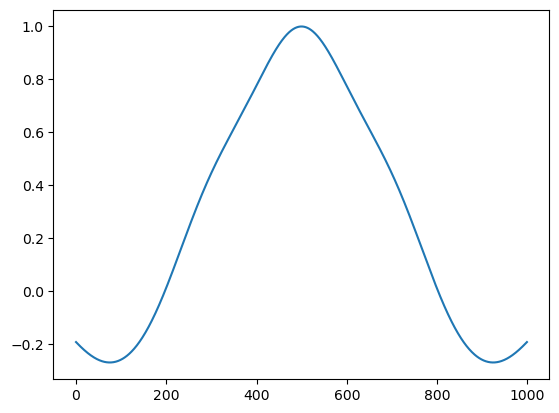

In [130]:
plt.plot(mu)

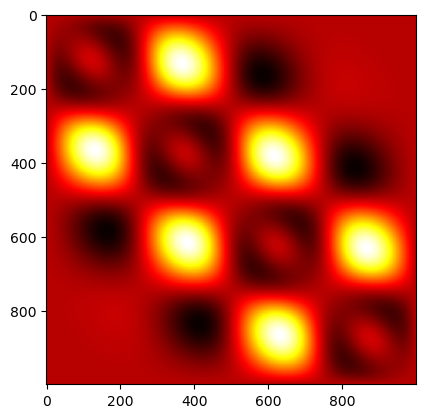

In [131]:
plt.imshow(sigma, cmap='hot', interpolation='nearest')
plt.show()

In [132]:
a = np.array([[1,2,3],[4,5,6], [7,8,9]])
np.hstack((a,a))

array([[1, 2, 3, 1, 2, 3],
       [4, 5, 6, 4, 5, 6],
       [7, 8, 9, 7, 8, 9]])

**Exercise 15.4**  Derive the relation $k_{f \nabla }(x, x')_i = \text{cov}(f(x), \frac{\partial}{\partial x'_i} f(x')) = \frac{\partial}{\partial x'_i} k_{ff}(x, x')$.

**Answer:**

$$
\begin{align}
k_{f \nabla }(x, x')_i &= \text{cov}(f(x), \frac{\partial}{\partial x'_i} f(x')) \\
&= \mathbb{E}\left[ \left(f(x) - \mathbb{E}[f(x)]\right) \left(\frac{\partial}{\partial x'_i} f(x') - \mathbb{E}\left[\frac{\partial}{\partial x'_i} f(x')\right]\right) \right] \\
&= \mathbb{E}\left[ \left(f(x) - \mathbb{E}[f(x)]\right) \left(\frac{\partial}{\partial x'_i} f(x') - \frac{\partial}{\partial x'_i}\mathbb{E}\left[ f(x')\right]\right) \right]\,\,\text{since the derivative is a linear operator} \\
&= \mathbb{E}\left[ \left(f(x) - \mathbb{E}[f(x)]\right) \frac{\partial}{\partial x'_i}\left( f(x') - \mathbb{E}\left[ f(x')\right]\right) \right] \\
&= \frac{\partial}{\partial x'_i}\mathbb{E}\left[ \left(f(x) - \mathbb{E}[f(x)]\right) \left( f(x')- \mathbb{E}\left[ f(x')\right]\right) \right]\\
&= \frac{\partial}{\partial x'_i}\text{cov}(f(x), f(x')) \\
&= \frac{\partial}{\partial x'_i} k_{ff}(x, x')
\end{align}
$$

**Exercise 15.5**  Suppose we have a multivariate Gaussian distribution over two variables $a$ and $b$. Show that the variance of the conditional distribution over $a$ given $b$ is no greater than the variance of the marginal distribution over $a$. Does this make intuitive sense?

**Answer:** The variance of the conditional distribution over $a$ given $b$ is given by:

$$
\text{var}(a|b) = \mathbf{A} - \mathbf{C} \mathbf{B}^{-1} \mathbf{C}^\top
$$

This must be positive in order for the covariance matrix to be positive semi-definite. Therefore:

$$
\mathbf{A} \geq\mathbf{C} \mathbf{B}^{-1} \mathbf{C}^\top
$$

**Exercise 15.6**  Suppose we observe many outliers while sampling, that is, we observe samples that do not fall within the confidence interval given by the Gaussian process. This means the probabilistic model we chose is not appropriate. What can we do?

**Answer:** We different kernel function and/or change the characteristic length scale of the kernel function.

** Exercise 15.7**  Consider model selection for the function evaluation pairs $(x, y)$:

$$
\{(1, 0),(2, -1),(3, -2),(4, 1),(5, 0)\}
$$

Use leave-one-out cross-validation to select the kernel that maximizes the likelihood of predicting the withheld pair given a Gaussian process over the other pairs in the fold. Assume zero mean with no noise. Select from the kernels:

$$
\begin{align}
&\text{exp}\left(-||x - x'||\right)\\
&\text{exp}\left(-||x - x'||^2\right)\\
&\left(1+||x-x'||\right)^{-1}\\
&\left(1+||x-x'||^2\right)^{-1}\\
&\left(1+||x-x'||\right)^{-2}
\end{align}
$$


**Answer:**

In [133]:
def kernal1(x,x_p):
    return np.exp(-np.linalg.norm(x-x_p))

def kernal2(x,x_p):
    return np.exp(-np.linalg.norm(x-x_p)**2)

def kernal3(x,x_p):
    return 1/(1+np.linalg.norm(x-x_p))

def kernal4(x,x_p):
    return 1/(1+np.linalg.norm(x-x_p)**2)

def kernal5(x,x_p):
    return 1/((1+np.linalg.norm(x-x_p))**2)

In [134]:
def log_likelihood(x,y, kernal):
    K = np.zeros((len(x),len(x)))
    for i, element1 in enumerate(x):
        for j, element2 in enumerate(x):
            K[i, j] = kernal(element1, element2)

    return -len(x)/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(K))-1/2*y.T @ np.linalg.inv(K) @ y

In [137]:
x = [1,2,3,4,5]
y = [0,-1,-2,1,0]

loo = LeaveOneOut()

kernals = [kernal1, kernal2, kernal3, kernal4, kernal5]

result={}

for k in kernals:
    error = []
    for train_index, test_index in loo.split(x):
        X_train, X_test = np.array(x)[train_index], np.array(x)[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        error.append(log_likelihood(X_train, y_train, k))
    result[k] = np.mean(error)

print(result)

{<function kernal1 at 0x0000029E25503790>: -6.505405280068042, <function kernal2 at 0x0000029E74110EE0>: -6.494367036428061, <function kernal3 at 0x0000029E75AAC3A0>: -7.015220815097157, <function kernal4 at 0x0000029E75AAC040>: -7.027304983747895, <function kernal5 at 0x0000029E75AAC0D0>: -6.279055618500088}


The best kernal is the one with the highest log likelihood, hence it's $\left(1+||x-x'||\right)^{-2}$.